In [1]:
%cd ../
!pwd

/home/yoshio/git/second.pytorch
/home/yoshio/git/second.pytorch


In [71]:
import os
import pickle
from pathlib import Path
from functools import partial
import re
import json

import numpy as np
from scipy.special import logit, expit
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss, precision_score, log_loss
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch

plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
plt.rcParams['font.size'] = 20                  # フォントサイズ

In [3]:
def expected_calibration_error(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1., n_bins + 1, endpoint=True)
    binids = np.digitize(y_prob, bins) - 1
    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    acc = bin_true[nonzero] / bin_total[nonzero]
    conf = bin_sums[nonzero] / bin_total[nonzero]
    return np.sum(np.abs(acc - conf) * bin_total[nonzero]) / bin_total.sum()

In [4]:
KITTI_INFO = Path(os.environ.get("KITTI_INFO", "/hdd/kitti/kitti_infos_val.pkl"))
# CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-onecycle.config")
CONF = os.environ.get("CONF", "pointpillars/car/xyres_16.config")
# MODEL = os.environ.get("MODEL", "pointpillars-car-16-onecycle")
MODEL = os.environ.get("MODEL", "pointpillars-car-16")
print(KITTI_INFO, CONF, MODEL)

MODEL_DIR = Path(f"./model/{MODEL}")
checkpoint_json = json.loads((MODEL_DIR / "checkpoints.json").read_text())
GSTEP = int(re.search(r"voxelnet-(\d+)\.tckpt", checkpoint_json["latest_ckpt"]["voxelnet"]).group(1))
print("latest step:", GSTEP)

RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/detections_kitti.pkl")
DATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result_kitti.pkl")
MODEL_WEIGHT = MODEL_DIR / f"voxelnet-{GSTEP}.tckpt"

/hdd/kitti/kitti_infos_val.pkl pointpillars/car/xyres_16.config pointpillars-car-16
latest step: 296960


In [5]:
with KITTI_INFO.open("rb") as f:
    gts = pickle.load(f)

with RAWDATA.open("rb") as f:
    rawdets = pickle.load(f)

with DATA.open("rb") as f:
    dets = pickle.load(f)

In [6]:
assert(np.all([np.allclose(_dets["score"], _rawdets["score"]) for _dets, _rawdets in zip(dets, rawdets)]))

# Conditional Calibration of KITTI Dataset Car difficulty:2 3DIoU@0.70

In [82]:
data = {
    "y_true": [],
    "conf": [],
    "X": [],
    "Y": [],
    "Z": [],
    "W": [], # width
    "L": [], # longitude
    "H": [], # height
    "num_points_in_det": [],
    "hull_lidar": [],
    "hull_bev": [],
    "sample_idx": [],
    "rot": [],
}

for i, (det, gt) in enumerate(tqdm(zip(dets, gts), total=len(dets))):
    result = det["official/3d_0.70/2/bin"]
    mask = result != 0 # remove 'ignore' detections
    data["y_true"].append(np.where(result[mask] == 1, 1, 0))
    data["conf"].append(det["score"][mask])
    data["X"].append(det["location"][mask,0])
    data["Y"].append(det["location"][mask,1])
    data["Z"].append(det["location"][mask,2])
    data["W"].append(det["dimensions"][mask,0])
    data["L"].append(det["dimensions"][mask,1])
    data["H"].append(det["dimensions"][mask,2])
    data["rot"].append(det["rotation_y"][mask] % (2*np.pi))
    data["num_points_in_det"].append(det["num_points_in_det"][mask])
    data["hull_lidar"].append(det["hull_volumes_in_det"][mask])
    data["hull_bev"].append(det["hull_bev_areas_in_det"][mask])
    data["sample_idx"].append(np.full(mask.sum(), i))

df = pd.DataFrame({key: np.concatenate(val) for key, val in data.items()})

  0%|          | 0/3769 [00:00<?, ?it/s]

In [85]:
df["sqrt_points"] = np.sqrt(df.num_points_in_det)
df["distance"] = np.sqrt(df.X ** 2 + df.Z ** 2)
df["angle"] = np.arctan2(df.X, df.Z)
df["hull_lidar_ratio"] = df.hull_lidar / (df.W * df.H * df.L)
df["hull_bev_ratio"] = df.hull_bev / (df.W * df.L)
df.head()

,y_true,conf,X,Y,Z,W,L,H,num_points_in_det,hull_lidar,hull_bev,sample_idx,rot,sqrt_points,distance,angle,hull_lidar_ratio,hull_bev_ratio
0,0,0.216198,-19.975688,2.306136,39.413959,3.787091,1.528061,1.584253,20,0.224913,0.601127,0,4.648231,4.472136,44.186969,-0.469087,0.024533,0.103877
1,0,0.211095,-25.132546,2.837855,30.316721,3.555773,1.467239,1.615633,18,0.190654,0.899083,0,4.467416,4.242641,39.379543,-0.692175,0.022619,0.172332
2,0,0.208583,7.115473,1.662149,29.307824,3.570137,1.501930,1.569420,16,0.213014,1.890528,0,1.713974,4.000000,30.159220,0.238176,0.025312,0.352573
3,0,0.176288,-25.058479,2.111207,34.355210,3.811384,1.527051,1.633206,84,2.695391,3.880743,0,4.739570,9.165151,42.523027,-0.630182,0.283560,0.666774
4,0,0.145128,8.225302,1.534155,28.086108,3.802566,1.513933,1.609617,5,0.000049,0.192590,0,3.342084,2.236068,29.265766,0.284894,0.000005,0.033454


## EDA

### Hist of gt positions

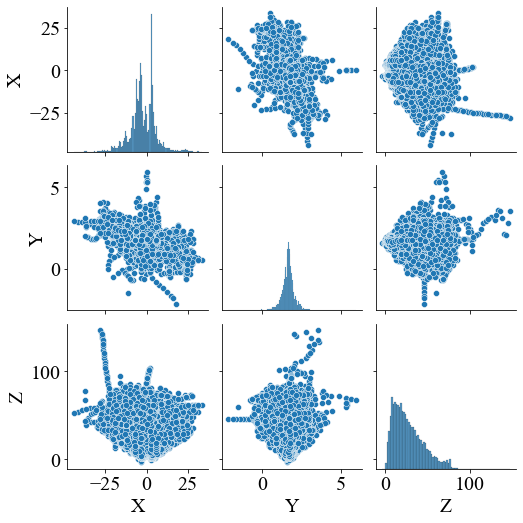

In [9]:
gt_data = {
    "X": [],
    "Y": [],
    "Z": [],
    "points": [],
}

for g in gts:
    mask = g["annos"]["index"] >= 0
    gt_data["X"].append(g["annos"]["location"][mask, 0])
    gt_data["Y"].append(g["annos"]["location"][mask, 1])
    gt_data["Z"].append(g["annos"]["location"][mask, 2])
    gt_data["points"].append(g["annos"]["num_points_in_gt"][mask])

gt_df = pd.DataFrame({key: np.concatenate(val) for key, val in gt_data.items()})
gt_df["angle"] = np.arctan2(gt_df.X, gt_df.Z)
gt_df["angle_deg"] = np.arctan2(gt_df.X, gt_df.Z) * 180 / np.pi
sns.pairplot(gt_df[["X", "Y", "Z"]])
plt.show()

In [10]:
gt_df.describe()

,X,Y,Z,points,angle,angle_deg
count,20870.000000,20870.000000,20870.000000,20870.000000,20870.000000,20870.000000
mean,-2.207046,1.647513,27.297164,177.576761,-0.081177,-4.651102
std,7.436291,0.435298,17.863289,300.082992,0.349523,20.026215
min,-44.030000,-2.140000,-3.550000,0.000000,-2.369033,-135.735569
25%,-6.180000,1.460000,13.282500,21.000000,-0.308833,-17.694823
50%,-2.840000,1.660000,23.460000,64.000000,-0.093162,-5.337793
75%,2.760000,1.850000,37.940000,206.000000,0.128844,7.382206
max,33.400000,5.930000,146.850000,4874.000000,1.778852,101.920739


### hist of det locations

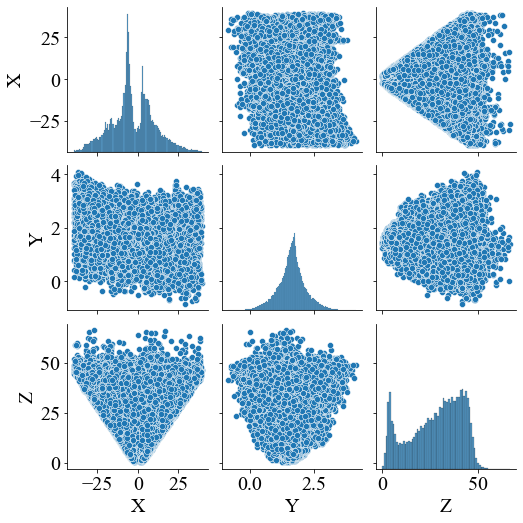

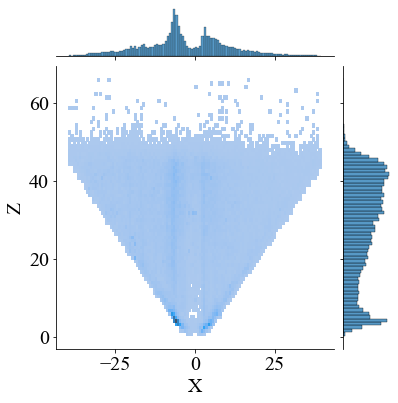

In [11]:
sns.pairplot(df[["X", "Y", "Z"]])
plt.show()

sns.jointplot(data=df, x="X", y="Z", kind="hist")
plt.show()

### hist of num_points

2456


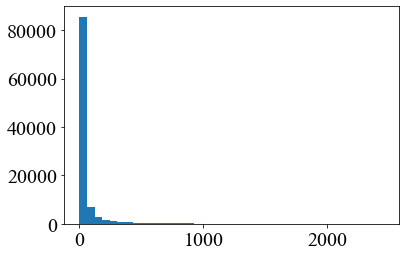

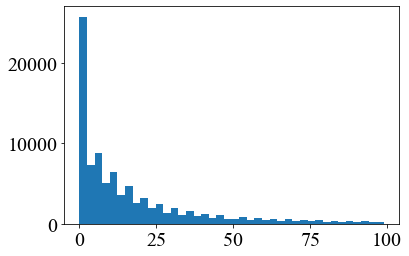

In [12]:
num_points_in_det = df.num_points_in_det.to_numpy()
print(num_points_in_det.max())
plt.hist(num_points_in_det, bins=40)
plt.show()

plt.hist(num_points_in_det[num_points_in_det < 100], bins=40)
plt.show()

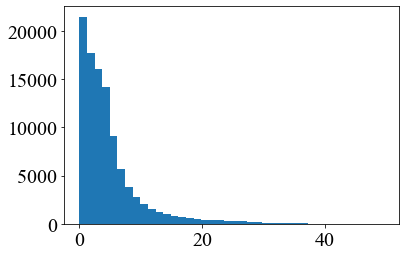

In [13]:
plt.hist(df.sqrt_points.to_numpy(), bins=40)
plt.show()

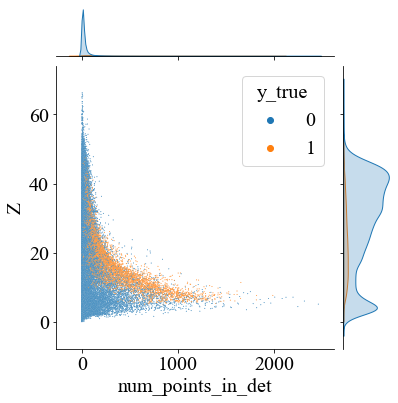

In [14]:
sns.jointplot(data=df, x="num_points_in_det", y="Z", hue="y_true", joint_kws={"s": 1})

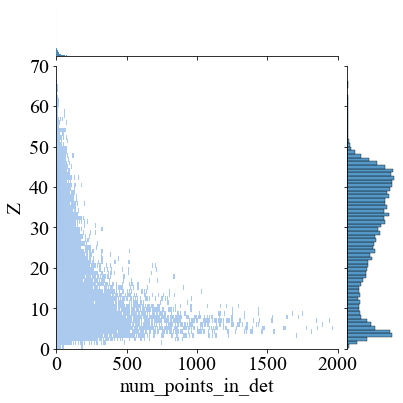

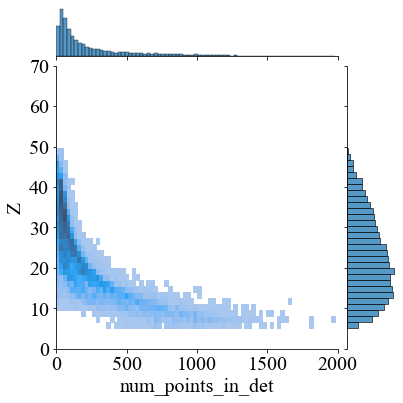

In [15]:
sns.jointplot(data=df[df.y_true == 0], x="num_points_in_det", y="Z", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
sns.jointplot(data=df[df.y_true == 1], x="num_points_in_det", y="Z", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
plt.show()

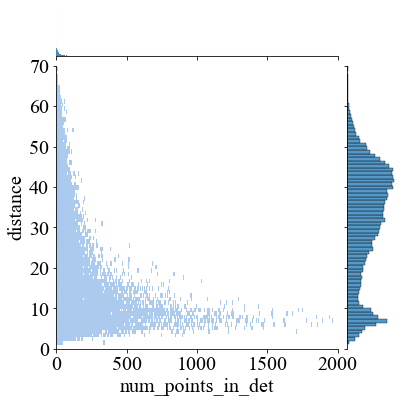

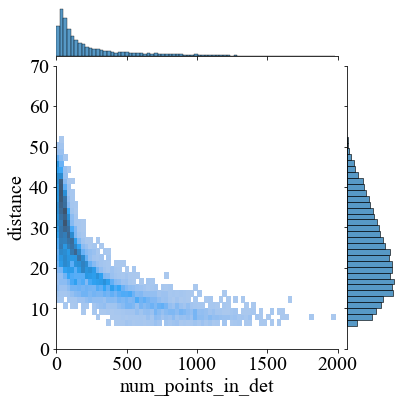

In [16]:
sns.jointplot(data=df[df.y_true == 0], x="num_points_in_det", y="distance", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
sns.jointplot(data=df[df.y_true == 1], x="num_points_in_det", y="distance", kind="hist",
	ylim=(0, 70), xlim=(0, 2000))
plt.show()

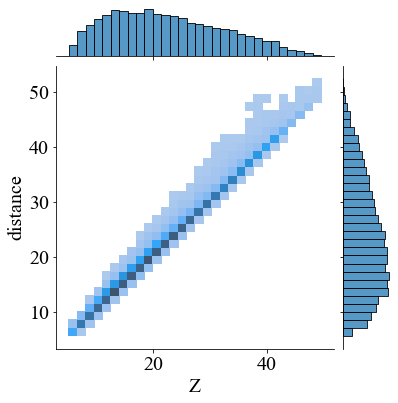

In [17]:
sns.jointplot(data=df[df.y_true == 1], x="Z", y="distance", kind="hist")

## D-ECE

<BarContainer object of 20 artists>

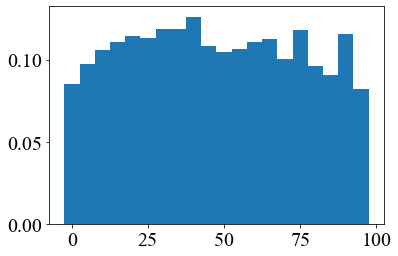

In [18]:
n_pbins = 20
pbins = np.linspace(0, 100, n_pbins+1, endpoint=True)
pbinids = np.digitize(num_points_in_det, pbins) - 1

dece = [expected_calibration_error(df.y_true[pbinids == i], df.conf[pbinids == i], n_bins=15) for i in range(n_pbins)]
plt.bar(pbins[:-1], dece, width=pbins[1]-pbins[0])

<BarContainer object of 10 artists>

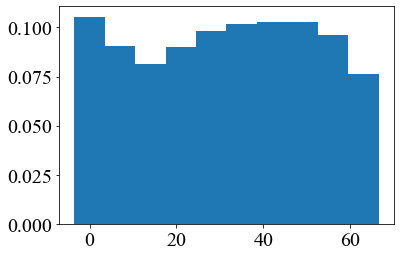

In [19]:
n_zbins = 10
zbins = np.linspace(0, 70, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.Z.to_numpy(), zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])

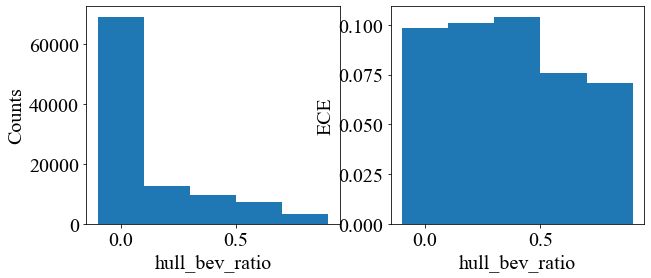

In [20]:
n_zbins = 5
zbins = np.linspace(0, 1.0, n_zbins+1, endpoint=True)

zbinids = np.digitize(df.hull_bev_ratio.to_numpy(), zbins) - 1
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.bar(zbins[:-1], [len(df.y_true[zbinids == i]) for i in range(n_zbins)], width=zbins[1]-zbins[0])
plt.ylabel("Counts")
plt.xlabel("hull_bev_ratio")

plt.subplot(1,2,2)
zbinids = np.digitize(df.hull_bev_ratio.to_numpy(), zbins) - 1
dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])
plt.ylabel("ECE")
plt.xlabel("hull_bev_ratio")

plt.show()

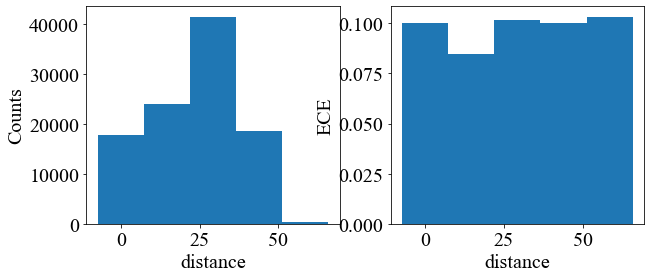

In [21]:
n_zbins = 5
zbins = np.linspace(0, df.distance.max(), n_zbins+1, endpoint=True)

zbinids = np.digitize(df.distance.to_numpy(), zbins) - 1
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.bar(zbins[:-1], [len(df.y_true[zbinids == i]) for i in range(n_zbins)], width=zbins[1]-zbins[0])
plt.ylabel("Counts")
plt.xlabel("distance")

plt.subplot(1,2,2)
dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])
plt.ylabel("ECE")
plt.xlabel("distance")

plt.show()


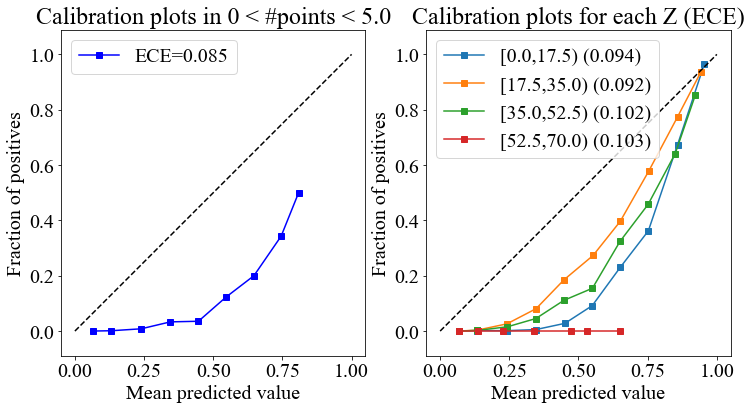

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
prob_true, prob_pred = calibration_curve(df.y_true[pbinids == 0], df.conf[pbinids == 0], n_bins=10)
ece = expected_calibration_error(df.y_true[pbinids == 0], df.conf[pbinids == 0], n_bins=10)
plt.title(f"Calibration plots in 0 < #points < {pbins[1]}")
plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()

plt.plot([0,1], [0,1], "k--")
plt.axis("equal")

plt.subplot(1,2,2)
n_zbins = 4
zbins = np.linspace(0, 70, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.Z.to_numpy(), zbins) - 1
plt.title(f"Calibration plots for each Z (ECE)")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="[%.1f,%.1f) (%.3f)"%(zbins[zi], zbins[zi+1], ece))
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend(loc="upper left")

plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()

In [64]:
ece_data = {
    "method": [],
    "angle": [],
    "ECE": [],
}

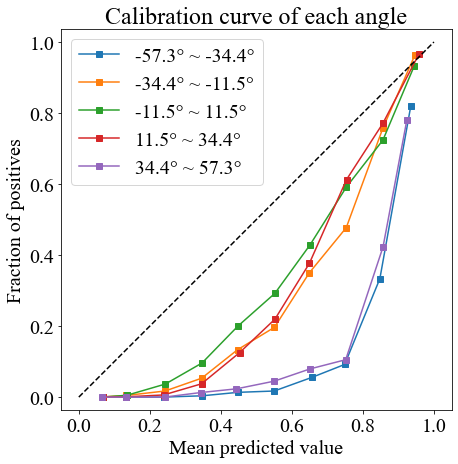

In [65]:
n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()

plt.figure(figsize=(7,7))
n_zbins = 5
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
plt.title(f"Calibration curve of each angle")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f° ~ %.1f°"%(zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["method"].append("baseline")
    ece_data["angle"].append("%.1f° ~ %.1f°" % (zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["ECE"].append(ece)
ece_data["method"].append("baseline")
ece_data["angle"].append("D-ECE")
ece_data["ECE"].append(dece_mean)
ece_data["method"].append("baseline")
ece_data["angle"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf, n_bins=10))
ece_data["method"].append("baseline")
ece_data["angle"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf.astype(np.float64)))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()

What?!
lidarなのにカメラ画面端のcalibrationが悪化している

おそらくトレーニング・推論時に画面外の点群を削除してから推論を回しているため。
→画面外削除をせずに推論してから後処理すべきでは？

In [66]:
CV = 10

kf = KFold(CV, shuffle=False)
X = np.arange(df.sample_idx.max()+1)
calibed_true = []
calibed_pred = []
indices = []

for train_idx, val_idx in kf.split(X, X):
    trainset = df[df.sample_idx.isin(train_idx)]
    valset = df[df.sample_idx.isin(val_idx)]
    indices.append(valset.index.to_numpy())
    calibed_true.append(valset.y_true.to_numpy())

    X_train = logit(trainset.conf.to_numpy().reshape(-1, 1))
    X_val = logit(valset.conf.to_numpy().reshape(-1, 1))
    y_train = trainset.y_true.to_numpy()
    y_val = valset.y_true.to_numpy()

    inst = LogisticRegression(random_state=0, penalty='none').fit(X_train, y_train)
    calibed_pred.append(inst.predict_proba(X_val)[:,1])

calibed_true = np.concatenate(calibed_true)
calibed_pred = np.concatenate(calibed_pred)
indices = np.concatenate(indices)
assert np.all(indices == np.arange(len(df)))

df["conf_platt"] = calibed_pred

In [67]:
kf = KFold(CV, shuffle=False)
X = np.arange(df.sample_idx.max()+1)
calibed_true = []
calibed_pred = []
indices = []

for train_idx, val_idx in kf.split(X, X):
    trainset = df[df.sample_idx.isin(train_idx)]
    valset = df[df.sample_idx.isin(val_idx)]
    indices.append(valset.index.to_numpy())
    calibed_true.append(valset.y_true.to_numpy())

    X_train = trainset.conf.to_numpy().reshape(-1, 1)
    X_val = valset.conf.to_numpy().reshape(-1, 1)
    y_train = trainset.y_true.to_numpy()
    y_val = valset.y_true.to_numpy()

    inst = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip").fit(X_train, y_train)
    calibed_pred.append(inst.predict(X_val))

calibed_true = np.concatenate(calibed_true)
calibed_pred = np.concatenate(calibed_pred)
indices = np.concatenate(indices)
assert np.all(indices == np.arange(len(df)))

df["conf_isotonic"] = calibed_pred

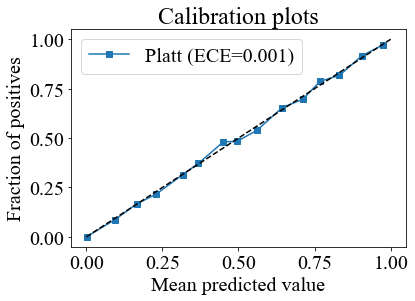

In [68]:
prob_true, prob_pred = calibration_curve(calibed_true, calibed_pred, n_bins=15)
ece = expected_calibration_error(calibed_true, calibed_pred, 15)
plt.title("Calibration plots")
plt.plot(prob_pred, prob_true, "s-", label="Platt (ECE=%.3f)"%ece)
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.show()

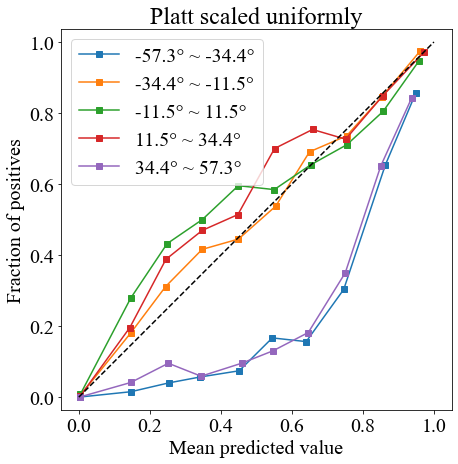

In [69]:
n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf_platt[zbinids == i], n_bins=15) for i in range(n_zbins)]
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()

plt.figure(figsize=(7,7))
n_zbins = 5
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
plt.title(f"Platt scaled uniformly")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_platt[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_platt[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f° ~ %.1f°"%(zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["method"].append("Platt scaling")
    ece_data["angle"].append("%.1f° ~ %.1f°" % (zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["ECE"].append(ece)
ece_data["method"].append("Platt scaling")
ece_data["angle"].append("D-ECE")
ece_data["ECE"].append(dece_mean)
ece_data["method"].append("Platt scaling")
ece_data["angle"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf_platt, n_bins=10))
ece_data["method"].append("Platt scaling")
ece_data["angle"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf_platt.astype(np.float64)))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()


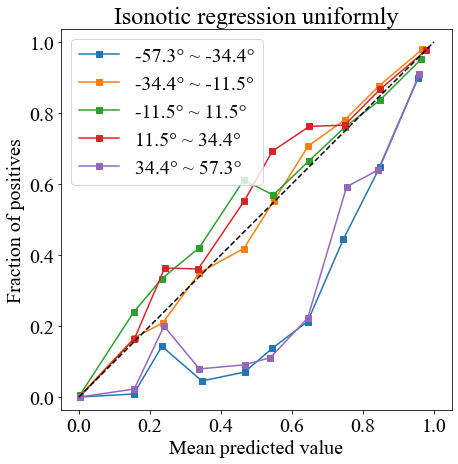

In [70]:
n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf_isotonic[zbinids == i], n_bins=15) for i in range(n_zbins)]
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()

plt.figure(figsize=(7,7))
n_zbins = 5
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
plt.title(f"Isonotic regression uniformly")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_isotonic[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_isotonic[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f° ~ %.1f°"%(zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["method"].append("isotonic regression")
    ece_data["angle"].append("%.1f° ~ %.1f°" % (zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["ECE"].append(ece)
ece_data["method"].append("isotonic regression")
ece_data["angle"].append("D-ECE")
ece_data["ECE"].append(dece_mean)
ece_data["method"].append("isotonic regression")
ece_data["angle"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf_isotonic, n_bins=10))
ece_data["method"].append("isotonic regression")
ece_data["angle"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf_isotonic.astype(np.float64)))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()

### Conditional Platt Scaling

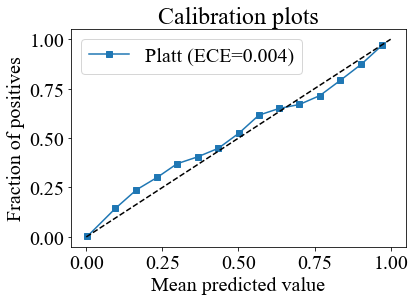

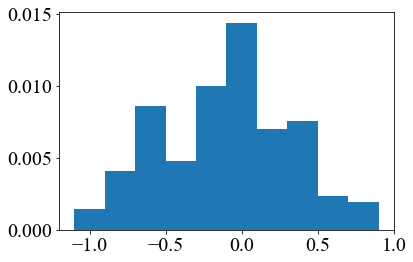

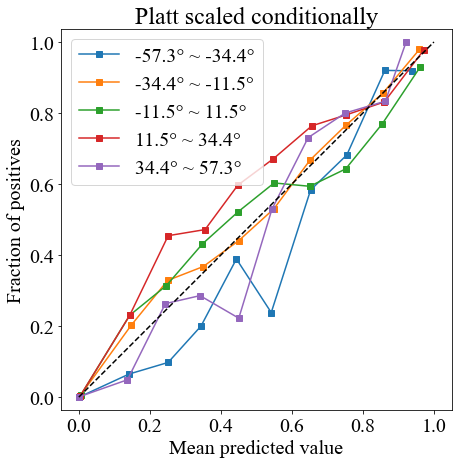

In [72]:
CV = 10

kf = KFold(CV, shuffle=False)
X = np.arange(df.sample_idx.max()+1)
calibed_true = []
calibed_pred = []
indices = []

for train_idx, val_idx in kf.split(X, X):
    trainset = df[df.sample_idx.isin(train_idx)]
    valset = df[df.sample_idx.isin(val_idx)]
    indices.append(valset.index.to_numpy())
    calibed_true.append(valset.y_true.to_numpy())

    X_train = np.vstack([logit(trainset.conf.to_numpy()), np.cos(trainset.angle.to_numpy()), np.sin(trainset.angle.to_numpy())]).T
    X_val = np.vstack([logit(valset.conf.to_numpy()), np.cos(valset.angle.to_numpy()), np.sin(valset.angle.to_numpy())]).T
    y_train = trainset.y_true.to_numpy()
    y_val = valset.y_true.to_numpy()

    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('estimator', LogisticRegression(random_state=0))
    ])
    inst = pipe.fit(X_train, y_train)
    calibed_pred.append(inst.predict_proba(X_val)[:,1])

calibed_true = np.concatenate(calibed_true)
calibed_pred = np.concatenate(calibed_pred)
indices = np.concatenate(indices)
assert np.all(indices == np.arange(len(df)))

df["conf_platt_cond"] = calibed_pred

prob_true, prob_pred = calibration_curve(calibed_true, calibed_pred, n_bins=15)
ece = expected_calibration_error(calibed_true, calibed_pred, 15)
plt.title("Calibration plots")
plt.plot(prob_pred, prob_true, "s-", label="Platt (ECE=%.3f)"%ece)
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.show()


n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1

dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf_platt_cond[zbinids == i], n_bins=15) for i in range(n_zbins)]
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()
plt.bar(zbins[:-1], dece, width=zbins[1]-zbins[0])
plt.show()

plt.figure(figsize=(7,7))
n_zbins = 5
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
plt.title(f"Platt scaled conditionally")
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_platt_cond[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_platt_cond[zbinids == zi], n_bins=10)
    plt.plot(prob_pred, prob_true, "s-", label="%.1f° ~ %.1f°"%(zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["method"].append("Conditional Platt scaling")
    ece_data["angle"].append("%.1f° ~ %.1f°" % (zbins[zi]/np.pi*180, zbins[zi+1]/np.pi*180))
    ece_data["ECE"].append(ece)
ece_data["method"].append("Conditional Platt scaling")
ece_data["angle"].append("D-ECE")
ece_data["ECE"].append(dece_mean)
ece_data["method"].append("Conditional Platt scaling")
ece_data["angle"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf_platt_cond, n_bins=10))
ece_data["method"].append("Conditional Platt scaling")
ece_data["angle"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf_platt_cond.astype(np.float64)))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()

In [73]:
ece_df = pd.DataFrame(ece_data)
indices = ece_df["method"].unique()
cols = ece_df["angle"].unique()

ece_df.pivot(index="method", columns="angle", values="ECE").loc[indices, cols]

angle,-57.3° ~ -34.4°,-34.4° ~ -11.5°,-11.5° ~ 11.5°,11.5° ~ 34.4°,34.4° ~ 57.3°,D-ECE,ECE,cross entropy loss
method,,,,,,,,
baseline,0.103238,0.096472,0.093933,0.089071,0.100548,0.096621,0.095676,0.149313
Platt scaling,0.009775,0.003774,0.012778,0.004113,0.008950,0.008926,0.002790,0.060693
isotonic regression,0.009736,0.003803,0.009500,0.003473,0.009010,0.008167,0.000635,0.060459
Conditional Platt scaling,0.002941,0.003556,0.011137,0.005508,0.001440,0.006976,0.003231,0.058272


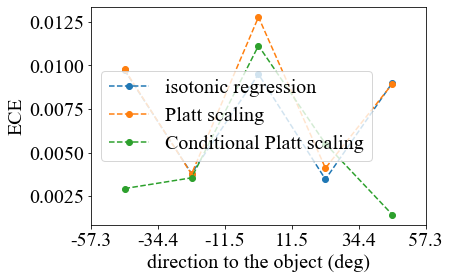

In [74]:
for m in ["baseline", "isotonic regression", "Platt scaling", "Conditional Platt scaling"][1:]:
    plt.plot(np.arange(5), ece_df[ece_df.method == m]["ECE"].iloc[:5], "o--", label=m)

plt.xticks([-0.5,0.5,1.5,2.5,3.5,4.5], [-57.3, -34.4, -11.5, 11.5, 34.4, 57.3])
plt.xlabel("direction to the object (deg)")
plt.ylabel("ECE")
plt.legend()
plt.show()

## convhull

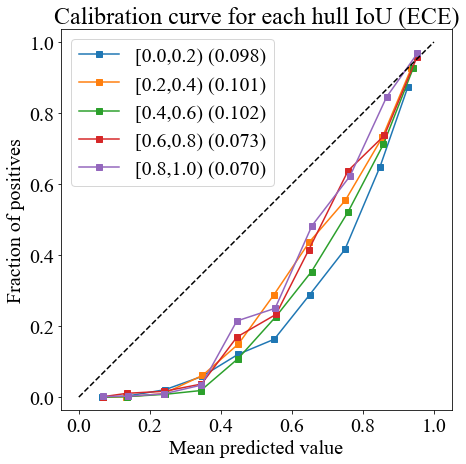

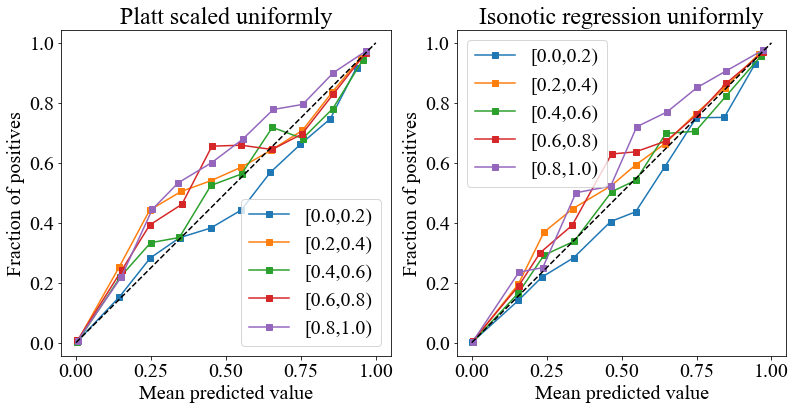

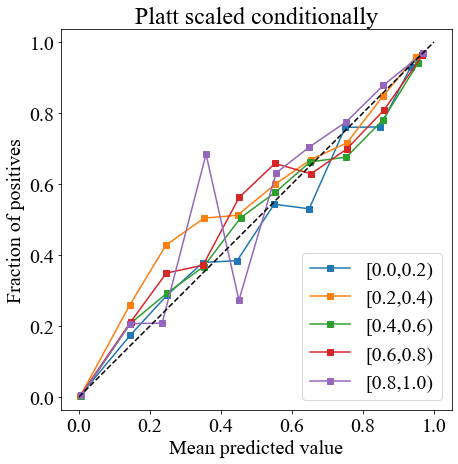

IoU,"[0.0,0.2)","[0.2,0.4)","[0.4,0.6)","[0.6,0.8)","[0.8,1.0)",D-ECE,ECE,cross entropy loss
method,,,,,,,,
baseline,0.098334,0.100545,0.102212,0.072784,0.070471,0.096205,0.095676,0.149313
Platt scaling,0.001864,0.008142,0.011197,0.009611,0.011189,0.004401,0.002790,0.060693
isotonic regression,0.002228,0.005670,0.006378,0.007915,0.014409,0.003866,0.000635,0.060459
Conditional Platt scaling,0.001733,0.008493,0.010922,0.009364,0.006907,0.004169,0.003188,0.060531


In [75]:
ece_data = {
    "method": [],
    "IoU": [],
    "ECE": [],
}

n_zbins = 5
zbins = np.linspace(0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.hull_bev_ratio.to_numpy(), zbins) - 1
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)


plt.figure(figsize=(7,7))
plt.title(f"Calibration curve for each hull IoU (ECE)")
dece = []
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf[zbinids == zi], n_bins=10)
    dece.append(ece)
    plt.plot(prob_pred, prob_true, "s-", label="[%.1f,%.1f) (%.3f)"%(zbins[zi], zbins[zi+1], ece))
    ece_data["method"].append("baseline")
    ece_data["IoU"].append("[%.1f,%.1f)" % (zbins[zi], zbins[zi+1]))
    ece_data["ECE"].append(ece)
ece_data["method"].append("baseline")
ece_data["IoU"].append("D-ECE")
ece_data["ECE"].append(np.sum(np.array(dece) * zbins_total) / zbins_total.sum())
ece_data["method"].append("baseline")
ece_data["IoU"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf, n_bins=10))
ece_data["method"].append("baseline")
ece_data["IoU"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf.astype(np.float64)))
plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend(loc="upper left")

plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()


plt.figure(figsize=(13,6))

plt.subplot(1,2,1)
plt.title(f"Platt scaled uniformly")
dece = []
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_platt[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_platt[zbinids == zi], n_bins=10)
    dece.append(ece)
    plt.plot(prob_pred, prob_true, "s-", label="[%.1f,%.1f)"%(zbins[zi], zbins[zi+1]))
    ece_data["method"].append("Platt scaling")
    ece_data["IoU"].append("[%.1f,%.1f)" % (zbins[zi], zbins[zi+1]))
    ece_data["ECE"].append(ece)
ece_data["method"].append("Platt scaling")
ece_data["IoU"].append("D-ECE")
ece_data["ECE"].append(np.sum(np.array(dece) * zbins_total) / zbins_total.sum())
ece_data["method"].append("Platt scaling")
ece_data["IoU"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf_platt, n_bins=10))
ece_data["method"].append("Platt scaling")
ece_data["IoU"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf_platt.astype(np.float64)))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")

plt.subplot(1,2,2)
plt.title(f"Isonotic regression uniformly")
dece = []
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_isotonic[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_isotonic[zbinids == zi], n_bins=10)
    dece.append(ece)
    plt.plot(prob_pred, prob_true, "s-", label="[%.1f,%.1f)"%(zbins[zi], zbins[zi+1]))
    ece_data["method"].append("isotonic regression")
    ece_data["IoU"].append("[%.1f,%.1f)" % (zbins[zi], zbins[zi+1]))
    ece_data["ECE"].append(ece)
ece_data["method"].append("isotonic regression")
ece_data["IoU"].append("D-ECE")
ece_data["ECE"].append(np.sum(np.array(dece) * zbins_total) / zbins_total.sum())
ece_data["method"].append("isotonic regression")
ece_data["IoU"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf_isotonic, n_bins=10))
ece_data["method"].append("isotonic regression")
ece_data["IoU"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf_isotonic.astype(np.float64)))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")

plt.show()


kf = KFold(CV, shuffle=False)
X = np.arange(df.sample_idx.max()+1)
calibed_true = []
calibed_pred = []
indices = []

for train_idx, val_idx in kf.split(X, X):
    trainset = df[df.sample_idx.isin(train_idx)]
    valset = df[df.sample_idx.isin(val_idx)]
    indices.append(valset.index.to_numpy())
    calibed_true.append(valset.y_true.to_numpy())

    X_train = np.vstack([logit(trainset.conf.to_numpy()), trainset.hull_bev_ratio.to_numpy()]).T
    X_val = np.vstack([logit(valset.conf.to_numpy()), valset.hull_bev_ratio.to_numpy()]).T
    y_train = trainset.y_true.to_numpy()
    y_val = valset.y_true.to_numpy()

    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('estimator', LogisticRegression(random_state=0))
    ])
    inst = pipe.fit(X_train, y_train)
    calibed_pred.append(inst.predict_proba(X_val)[:,1])

calibed_true = np.concatenate(calibed_true)
calibed_pred = np.concatenate(calibed_pred)
indices = np.concatenate(indices)
assert np.all(indices == np.arange(len(df)))

df["conf_platt_cond_hull"] = calibed_pred


plt.figure(figsize=(7,7))
plt.title(f"Platt scaled conditionally")
dece = []
for zi in range(n_zbins):
    prob_true, prob_pred = calibration_curve(df.y_true[zbinids == zi], df.conf_platt_cond_hull[zbinids == zi], n_bins=10)
    ece = expected_calibration_error(df.y_true[zbinids == zi], df.conf_platt_cond_hull[zbinids == zi], n_bins=10)
    dece.append(ece)
    plt.plot(prob_pred, prob_true, "s-", label="[%.1f,%.1f)"%(zbins[zi], zbins[zi+1]))
    ece_data["method"].append("Conditional Platt scaling")
    ece_data["IoU"].append("[%.1f,%.1f)" % (zbins[zi], zbins[zi+1]))
    ece_data["ECE"].append(ece)
ece_data["method"].append("Conditional Platt scaling")
ece_data["IoU"].append("D-ECE")
ece_data["ECE"].append(np.sum(np.array(dece) * zbins_total) / zbins_total.sum())
ece_data["method"].append("Conditional Platt scaling")
ece_data["IoU"].append("ECE")
ece_data["ECE"].append(expected_calibration_error(df.y_true, df.conf_platt_cond_hull, n_bins=10))
ece_data["method"].append("Conditional Platt scaling")
ece_data["IoU"].append("cross entropy loss")
ece_data["ECE"].append(log_loss(df.y_true, df.conf_platt_cond_hull.astype(np.float64)))

plt.xlim(-0.05, 1.05)
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.legend()
plt.plot([0,1], [0,1], "k--")
plt.axis("equal")
plt.show()

ece_df = pd.DataFrame(ece_data)
indices = ece_df["method"].unique()
cols = ece_df["IoU"].unique()

ece_df.pivot(index="method", columns="IoU", values="ECE").loc[indices, cols]

## everything

0.05652619635428841


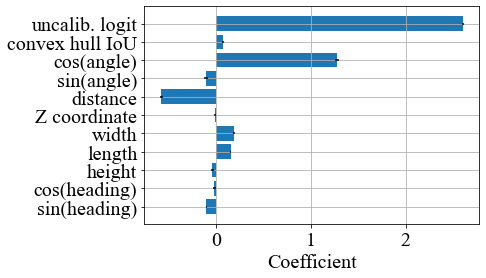

In [101]:
kf = KFold(CV, shuffle=False)
X = np.arange(df.sample_idx.max()+1)
calibed_true = []
calibed_pred = []
indices = []
imp = []

for train_idx, val_idx in kf.split(X, X):
    trainset = df[df.sample_idx.isin(train_idx)]
    valset = df[df.sample_idx.isin(val_idx)]
    indices.append(valset.index.to_numpy())
    calibed_true.append(valset.y_true.to_numpy())

    X_train = np.vstack([
        logit(trainset.conf.to_numpy()),
        trainset.hull_bev_ratio.to_numpy(),
        np.cos(trainset.angle.to_numpy()), np.sin(trainset.angle.to_numpy()),
        trainset.distance.to_numpy(),
        trainset.Y.to_numpy(),
        trainset.W.to_numpy(),
        trainset.L.to_numpy(),
        trainset.H.to_numpy(),
        np.cos(trainset.rot.to_numpy()), np.sin(trainset.rot.to_numpy()),
    ]).T
    X_val = np.vstack([
        logit(valset.conf.to_numpy()),
        valset.hull_bev_ratio.to_numpy(),
        np.cos(valset.angle.to_numpy()), np.sin(valset.angle.to_numpy()),
        valset.distance.to_numpy(),
        valset.Y.to_numpy(),
        valset.W.to_numpy(),
        valset.L.to_numpy(),
        valset.H.to_numpy(),
        np.cos(valset.rot.to_numpy()), np.sin(valset.rot.to_numpy()),
    ]).T
    y_train = trainset.y_true.to_numpy()
    y_val = valset.y_true.to_numpy()

    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('estimator', LogisticRegression(random_state=0))
    ])
    inst = pipe.fit(X_train, y_train)
    calibed_pred.append(inst.predict_proba(X_val)[:,1])
    imp.append(pipe.steps[1][1].coef_[0])

calibed_true = np.concatenate(calibed_true)
calibed_pred = np.concatenate(calibed_pred)
indices = np.concatenate(indices)
print(log_loss(calibed_true, calibed_pred.astype(np.float64)))
feature = ("uncalib. logit", "convex hull IoU", "cos(angle)", "sin(angle)", "distance", "Z coordinate", "width", "length", "height", "cos(heading)", "sin(heading)")

fig, ax = plt.subplots()
ax.barh(np.arange(len(feature)), np.mean(imp, axis=0), xerr=np.std(imp, axis=0, ddof=1))
ax.set_yticks(np.arange(len(feature)))
ax.set_yticklabels(feature)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Coefficient')
ax.grid(True)
plt.show()

In [90]:
pipe.steps[1][1]

LogisticRegression(random_state=0)

## mIOU

In [35]:
y_true = df.y_true
X = np.vstack([logit(df.conf.to_numpy()), np.cos(df.angle.to_numpy()), np.sin(df.angle.to_numpy())]).T

RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/detections_kitti.pkl")

with RAWDATA.open("rb") as f:
    detections = pickle.load(f)

platt = LogisticRegression(random_state=0).fit(X, y_true)
for det in tqdm(detections):
    angle = np.arctan2(det["location"][:,0], det["location"][:,2])
    testX = np.vstack([logit(det["score"]), np.cos(angle), np.sin(angle)]).T
    if len(testX) == 0:
        continue
    det["score"] = platt.predict_proba(testX)[:,1]
    arg = np.argsort(det["score"])[::-1]
    for key in det.keys():
        if key == "metadata":
            continue
        det[key] = det[key][arg]

OUTPUT_POST_DIR = Path(f"./model/{MODEL}/condcalib_absangle/eval_results/step_{GSTEP}")
OUTPUT_POST_DIR.mkdir(exist_ok=True, parents=True)

with (OUTPUT_POST_DIR / "detections_kitti.pkl").open("wb") as f:
    pickle.dump(detections, f)

  0%|          | 0/3769 [00:00<?, ?it/s]

In [38]:
command = f"docker run --rm -it --gpus all \
		-v /hdd/kitti:/app/data \
		-v $PWD/model:/app/model \
		second.pytorch:latest \
		python ./pytorch/train.py evaluate_from_result \
			--config_path=./configs/{CONF} \
			--result_path_step=/app/model/{MODEL}/condcalib_absangle/eval_results/step_{GSTEP} \
			--measure_time=True \
			--use_detections_kitti=True \
			--batch_size=1"
!bash -c "{command}"

/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_CUDA_DRIVER=/usr/lib/x86_64-linux-gnu/libcuda.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('https://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignor

In [39]:
def show_calibration(y_true, y_pred, n_bins=15):
    plt.figure(figsize=(10, 5))
    plt.suptitle("KITTI Dataset Car difficulty:2 3DIoU@0.70")
    plt.subplot(1,2,1)
    plt.title("Raw predicted value")
    plt.hist(y_pred, range=(0, 1), bins=n_bins)
    plt.xlabel("Predicted value")
    plt.ylabel("Count")
    
    plt.subplot(1,2,2)
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)
    ece = expected_calibration_error(y_true, y_pred, n_bins=n_bins)
    plt.title("Raw Calibration plots")
    plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
    plt.xlim(-0.05, 1.05)
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.legend()
    
    plt.plot([0,1], [0,1], "k--")
    plt.show()

In [86]:
import re

with (OUTPUT_POST_DIR / "result_kitti.pkl").open("rb") as f:
    dets_calib = pickle.load(f)

cy_true_li = []
cy_pred_li = []

for det in tqdm(dets_calib):
    result = det["official/3d_0.70/2/bin"]
    mask = result != 0 # remove 'ignore' detections
    cy_true_li.append(np.where(result[mask] == 1, 1, 0))
    cy_pred_li.append(det["score"][mask])

cy_true = np.concatenate(cy_true_li)
cy_pred = np.concatenate(cy_pred_li)

show_calibration(cy_true, cy_pred)

with (MODEL_DIR / f"eval_results/step_{GSTEP}/result_evaluation.pkl").open("rb") as f:
    result = pickle.load(f)

with (OUTPUT_POST_DIR / "result_evaluation.pkl").open("rb") as f:
    result_calib = pickle.load(f)

match = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result["official"].split("\n")[3])
match_calib = re.search(r"AP:([\d\.]+), ([\d\.]+), ([\d\.]+)", result_calib["official"].split("\n")[3])

n_zbins = 10
zbins = np.linspace(-1.0, 1.0, n_zbins+1, endpoint=True)
zbinids = np.digitize(df.angle, zbins) - 1
zbins_total = np.bincount(zbinids.clip(0, n_zbins-1), minlength=n_zbins)
dece = [expected_calibration_error(df.y_true[zbinids == i], df.conf[zbinids == i], n_bins=15) for i in range(n_zbins)]
dece_mean = np.sum(np.array(dece) * zbins_total) / zbins_total.sum()
cdece = [expected_calibration_error(cy_true[zbinids == i], cy_pred[zbinids == i], n_bins=15) for i in range(n_zbins)]
cdece_mean = np.sum(np.array(cdece) * zbins_total) / zbins_total.sum()

df = pd.DataFrame({
    "method": ["baseline", "Platt scaling w/abs(angle)"],
    "ECE": [expected_calibration_error(df.y_true, df.conf, 15), expected_calibration_error(cy_true, cy_pred, 15)],
    "D-ECE": [dece_mean, cdece_mean],
    "Easy 3DIoU@0.7": [match.group(1), match_calib.group(1)],
    "Moderate 3DIoU@0.7": [match.group(2), match_calib.group(2)],
    "Hard 3DIoU@0.7": [match.group(3), match_calib.group(3)],
})
df.set_index("method")

NameError: name 'OUTPUT_POST_DIR' is not defined